In [30]:
import json
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>" # using OOV in <>
training_size = 23000
# total sample size = 26709

In [3]:
with open("sarcasm1.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

traning_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    traning_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 dropout_3 (Dropout)         (None, 100, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 48)                816       
                                                                 
 batch_normalization_3 (Batc  (None, 48)               192       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 48)               

In [31]:
num_epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    callbacks=[early_stopping], verbose=2)

Epoch 1/100
719/719 - 5s - loss: 0.2509 - accuracy: 0.8985 - val_loss: 0.3638 - val_accuracy: 0.8421 - 5s/epoch - 7ms/step
Epoch 2/100
719/719 - 5s - loss: 0.2526 - accuracy: 0.9001 - val_loss: 0.3780 - val_accuracy: 0.8379 - 5s/epoch - 7ms/step
Epoch 3/100
719/719 - 5s - loss: 0.2556 - accuracy: 0.8973 - val_loss: 0.4828 - val_accuracy: 0.7994 - 5s/epoch - 7ms/step
Epoch 4/100
719/719 - 5s - loss: 0.2515 - accuracy: 0.8993 - val_loss: 0.3596 - val_accuracy: 0.8430 - 5s/epoch - 6ms/step
Epoch 5/100
719/719 - 5s - loss: 0.2500 - accuracy: 0.9002 - val_loss: 0.3746 - val_accuracy: 0.8366 - 5s/epoch - 6ms/step
Epoch 6/100
719/719 - 5s - loss: 0.2494 - accuracy: 0.8988 - val_loss: 0.4082 - val_accuracy: 0.8226 - 5s/epoch - 6ms/step
Epoch 7/100
719/719 - 5s - loss: 0.2478 - accuracy: 0.9029 - val_loss: 0.3662 - val_accuracy: 0.8420 - 5s/epoch - 7ms/step
Epoch 7: early stopping


176/176 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2963
           1       0.85      0.80      0.83      2656

    accuracy                           0.84      5619
   macro avg       0.84      0.84      0.84      5619
weighted avg       0.84      0.84      0.84      5619



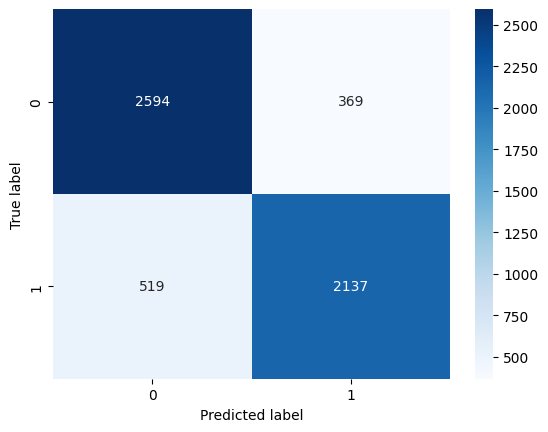

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels for testing data
y_pred = model.predict(testing_padded)
y_pred = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics
print(classification_report(testing_labels, y_pred))

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [39]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [37]:
testing = [ "Oh great, another meeting. Just what I needed to make my day complete.", 
            "The sun rises in the east and sets in the west.",
            "It’s okay if you don’t like me. Not everyone has good taste.",
            "The weather is great today.",
            "She is studying medicine to become a doctor.",
            "Oh, fantastic! Another Monday morning. I can't wait to spend the next eight hours in my cubicle."]
sequences = tokenizer.texts_to_sequences(testing)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))



1/1 [==============================] - 0s 58ms/step
[[0.808717  ]
 [0.00209232]
 [0.9700855 ]
 [0.03598567]
 [0.02516563]
 [0.7738395 ]]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b446489-87fb-4adc-bdae-1fb56e10a539' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>